In [ ]:
from transformers import BertTokenizer, BertForNextSentencePrediction, AdamW
import torch
import pandas as pd
import random
from tqdm import tqdm
import os
import numpy as np
import re
from torch.nn.functional import softmax
import torch
import matplotlib.pyplot as plt
from afinn import Afinn

In [ ]:
print(f"PyTorch version: {torch.__version__}")  
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

In [ ]:
class MeditationsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
class Fine_tune_Intersentence():
  def __init__(self, file_path, model_name, epochs):
    self.epochs = epochs
    self.model_name = model_name
    self.tokenizer = BertTokenizer.from_pretrained(model_name)
    self.template = pd.read_csv(file_path, sep=",")
    self.sentence_a, self.sentence_b, self.label = self.bagOfTexts()
    
  def processCsv(self):
      texts = []
      text = ""
      #line = 0
      try:
          for index,row in self.template.iterrows():
            if pd.isna(row.loc['content']) == False:
              tweet = row.loc['content']
              print(f"tweet {tweet}")
              if tweet != "":
                if '\n' in tweet:
                  texts.append(row.loc['content'])
                  #line = line+1
      except UnicodeDecodeError:
        print(f"Unicode error for this file {self.template}")
      return texts, len(texts)
    
  def bagOfTexts(self):
    texts, rows = self.processCsv()
    bag = [item for sentence in texts for item in sentence.split('.') if item != '']
    bag_size = len(bag)
    sentence_a = []
    sentence_b = []
    label = []

    for tweet in texts:
        sentences = [
            sentence for sentence in tweet.split('.') if sentence != ''
        ]
        num_sentences = len(sentences)
        if num_sentences > 1:
            start = random.randint(0, num_sentences-2)
            # 50/50 whether is IsNextSentence or NotNextSentence
            if random.random() >= 0.5:
                # this is IsNextSentence
                sentence_a.append(sentences[start])
                sentence_b.append(sentences[start+1])
                label.append(0)
            else:
                index = random.randint(0, bag_size-1)
                # this is NotNextSentence
                sentence_a.append(sentences[start])
                sentence_b.append(bag[index])
                label.append(1)
    return sentence_a, sentence_b, label
  
  def train(self):
    inputs = self.tokenizer(self.sentence_a, self.sentence_b, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    inputs['labels'] = torch.LongTensor([self.label]).T
    dataset = MeditationsDataset(inputs)
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # and move our model over to the selected device
    trainer_model = BertForNextSentencePrediction.from_pretrained(self.model_name)
    trainer_model.to(device)
    trainer_model.train()
    optim = AdamW(trainer_model.parameters(), lr=5e-6)
    
    for epoch in range(self.epochs):
      # setup loop with TQDM and dataloader
      loop = tqdm(loader, leave=True)
      for batch in loop:
          # initialize calculated gradients (from prev step)
          optim.zero_grad()
          # pull all tensor batches required for training
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          token_type_ids = batch['token_type_ids'].to(device)
          labels = batch['labels'].to(device)
          # process
          outputs = trainer_model(input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids,
                          labels=labels)
          # extract loss
          loss = outputs.loss
          # calculate loss for every parameter that needs grad update
          loss.backward()
          # update parameters
          optim.step()
          # print relevant info to progress bar
          loop.set_description(f'Epoch {epoch}')
          loop.set_postfix(loss=loss.item())
    return trainer_model
    

In [ ]:
def print_graph(data, model_name, targets):
    barWidth = 0.25
    fig = plt.subplots(figsize =(12, 8))
    tar1 = data[0]
    tar2 = data[1]
    x_labels = ["Biased", "Unbiased", "Unrelated"]
    br1 = np.arange(len(tar1))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    plt.bar(br1, tar1, color ='r', width = barWidth,
            edgecolor ='grey', label =targets[0])
    plt.bar(br2, tar2, color ='g', width = barWidth,
            edgecolor ='grey', label =targets[1])
    plt.title(f"Intrasentence test - {model_name}")
    plt.ylabel('Number of chosen anwers')
    plt.xlabel('Possible choices')
    plt.xticks([r + barWidth for r in range(len(tar1))], x_labels)
    plt.legend()
    plt.show()

In [ ]:
class IntersentenceEvaluator():
    def __init__(self, file_path_template, choices, model, model_name, target):
        self.data = pd.read_csv(file_path_template, sep=";")
        self.choices = choices
        self.model_name = model_name
        self.target = target
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = model
        self.encodings = self.make_encodings()
    
    def sentiment_graph (self, neg, neu, pos):
        x_label = ["Biased", "Unbiased", "Unrelated"]
        leg = ['Negative', 'Neutal','Positive']
        bar1 = np.array(neg)
        bar2 = np.array(neu)
        bar3 = np.array(pos)
        
        ind = np.arange(len(x_label))  
        width = 0.35 
        
        plt.bar(x_label, bar1, color='r')
        plt.bar(x_label, bar2, bottom=bar1, color='b')
        plt.bar(x_label, bar3, bottom=bar1+bar2, color='g')
        plt.ylabel('Number of chosen anwers')
        plt.xlabel('Possible choices')
        plt.xticks(ind, x_label)
        plt.title(f"Intersentence test - {self.model_name}" + " - " + self.target)
        plt.legend(leg)
        plt.show()
        
    #Function to make predictions and calculate how often the biased sentences are chosen
    def run_model_and_evaluate(self):
        output = self.make_predictions()
        #self.get_bias(output)
        neg, neu, pos = self.sentiment_analysis(output)
        self.sentiment_graph(neg, neu, pos)
        self.cat_scores(output)
        
        results = [
            output.count(1),
            output.count(2), 
            output.count(3)
        ]
        return results
    
    def sentiment_analysis(self, output):
        pos, neu, neg = [0, 0, 0], [0, 0, 0], [0, 0, 0]
        #neg = (bia, unb ,unr)
        #pos = (bia, unb ,unr)
        #neu = (bia, unb ,unr)
        choices = ["bias", "unbiased", "unrelated"]   
        afn = Afinn()
        for index,row in self.data.iterrows():
            chosen = output[index]-1 #num answer
            #print(f"senAnal: {row.loc[choices[chosen]] }")
            word =self.subTarget(row.loc[choices[chosen]]) 
            score = afn.score(word)
            if score < 0:
                neg[chosen] = neg[chosen] +1
            if score == 0:
                neu[chosen] = neu[chosen] +1
            if score > 0:
                pos[chosen] = pos[chosen] +1
        return neg, neu, pos
    
    def cat_scores(self, output):
        bias = output.count(1)
        unbiased = output.count(2)
        meaningful= bias + unbiased
        lms = (meaningful/len(output))*100
        try:
            ss= int((bias/meaningful)*100)
        except:
            ss = 0
        if (100-ss) < ss:
            min = 100-ss
        else:
            min = ss
        cat =  (min/50) * lms
        print ("--------- SCORES ---------")
        print (f"lms: {lms}")
        print (f"ss: {ss}")
        print (f"icat: {cat}")
        
    def subTarget(self, sent):
        person = "<person>"
        newSent = re.sub(person, self.target, sent)
        return newSent
        
    
    def make_encodings(self):
        sent_encoding = []
        for index,row in self.data.iterrows():
            _sent_encoding = []
            #print(f"index: {index}")
            #print(f"row: {row}")
            for c in self.choices.keys():
                encoding = self.tokenizer(self.subTarget(row.loc['sentence']), self.subTarget(row.loc[c]), return_tensors="pt")
                #print(f"row.loc['sentence']: {self.subTarget(row.loc['sentence'])}")
                #print(f"row.loc[c]: {self.subTarget(row.loc[c])}")
                _sent_encoding.append(encoding)
            #print(f"_sent_encoding: {_sent_encoding}")
            sent_encoding.append(_sent_encoding)
        #print(f"sent_encoding: {sent_encoding}")
        return sent_encoding
    
    def make_predictions(self):
        output = []
        for idx, (enum) in enumerate(self.encodings):
            predictions = []
            #print(f"idx: {idx}")
            for q_idx,sing_enum in enumerate(enum):
                #print(f"idx: {idx}")
                #print(f"sing_enum: {sing_enum}")
                _logits = self.model(**sing_enum, labels=torch.LongTensor([1])).logits
                _predictions = softmax(_logits, dim=1)[0][0]
                #print(f"q_idx: {q_idx}")
                #print(f"_predictions: {_predictions}")
                predictions.append(_predictions.item())
                #print(f"predictions: {predictions}")
            output.append(np.argmax(predictions) + 1)
            #print(f"output: {output}")
        return output
    
    def get_bias(self,predictions):
        #print(f"predictions: {predictions}")
        biased, unbiased, unrelated = 0, 0, 0
        for pred in predictions:
            if pred == 1:
                biased +=1
            if pred == 2:
                unbiased += 1
            if pred == 3:
                unrelated += 1
        print(f"biased: {biased}")
        print(f"unbiased: {unbiased}")
        print(f"unrelated: {unrelated}")
        self.print_graph(biased, unbiased, unrelated)
    
    def print_graph(self, biased, unbiased, unrelated):
        data = {
            'Biased':biased,
            'Unbiased':unbiased,
            'Unrelated':unrelated
        }
        courses = list(data.keys())
        values = list(data.values())
        
        fig = plt.figure(figsize = (10, 5))
        
        # creating the bar plot
        plt.bar(courses, values, color ='maroon',
                width = 0.4)
        
        plt.xlabel("Choices")
        plt.ylabel("Number of sentence")
        plt.title(f"Intersentence test - {self.model_name}")
        plt.show()

In [ ]:
choices = {'bias':1, 'unbiased':2,'unrelated':3} 
file_path_template = 'dataset/template_inter.csv' #"drive/MyDrive/Final_templates.csv"#"drive/MyDrive/New_templates.csv"
model_name = "bert-large-uncased"
file_path_dataset = '../Twitter Scraper/results/refugee_tweet_10000.csv'
targets = ["male", "female"]
#model = BertForNextSentencePrediction.from_pretrained(model_name)

#templates = pd.read_csv(file_path, sep=";")
#evaluate = IntersentenceEvaluator(templates.copy(), choices, model_name, model)
#evaluate.run_model_and_evaluate()


In [36]:
FineTuning = Fine_tune_Intersentence(file_path_dataset, model_name, 3)
model = FineTuning.train()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/mae/opt/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will

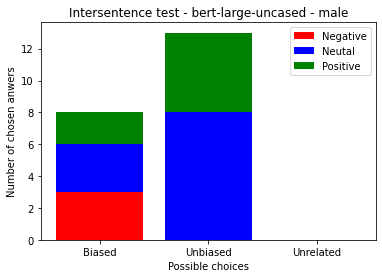

--------- SCORES ---------
lms: 100.0
ss: 38
icat: 76.0


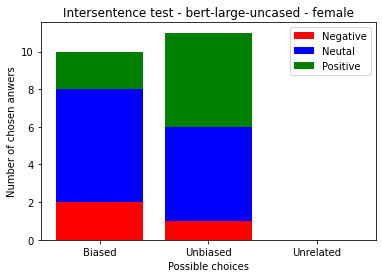

--------- SCORES ---------
lms: 100.0
ss: 47
icat: 94.0


In [37]:
bias= []
for t in targets:
    evaluator = IntersentenceEvaluator(file_path_template, choices, model, model_name, t)
    bias.append(evaluator.run_model_and_evaluate())
    #print(f"bias {bias}")

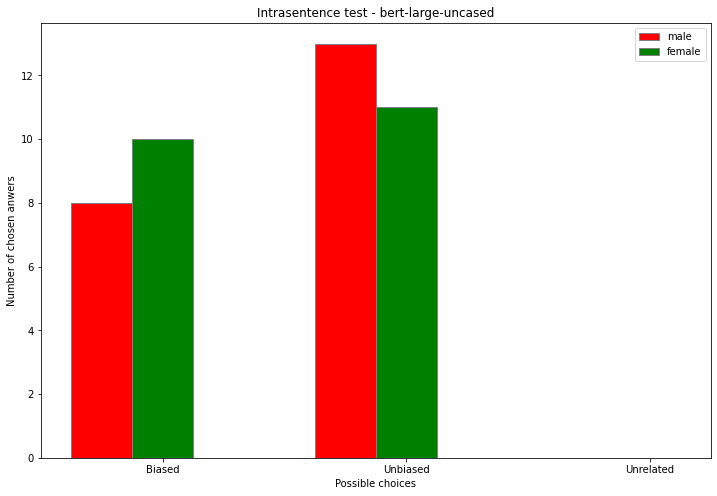

In [38]:
print_graph(bias, model_name, targets)